## <center>Inicio

In [1]:
# Importación de librerías

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import random

In [2]:
import re
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer

In [4]:
from sklearn.utils import shuffle

In [5]:
import xgboost as xgb

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization

In [ ]:
# Importación de los documentos

tw_train = pd.read_csv('./train.csv')
tw_test = pd.read_csv('./test.csv')
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

## <center>Text: Preprocesamiento y Feature Extraction

In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

regexes = {'hashtags':r'(#)+', 'mentions':r'(@)\w*', 'URLs':r'(http://)[a-zA-Z0-9./]*'}

referenceDF = pd.read_csv('./headlines_reference_values.csv').drop(columns = 'Unnamed: 0')
ref = referenceDF.loc[0]

basicStopwords = stopwords.words('english')
myStopwords = set(basicStopwords + list(punctuation))

In [7]:
def isInText(DF, feature):
    DF[feature[0]+'_in_t'] = 0   # Inicialización de la nueva columna
    for i in range(len(DF)):
        try:
            if (DF.loc[i, feature]).lower() in (DF.loc[i, 'text']).lower(): DF.loc[i, feature[0]+'_in_t'] = 1
        except:
            continue
        
def replace_contractions(text, mapping):
    noContText = []
    counter = 0
    for t in text.split(" "):
        if t.lower() in mapping:
            noContText.append(mapping[t.lower()])
            counter += 1
        else:
            noContText.append(t) 
    return [' '.join(noContText), counter]

def Qy(regex, text):   
    try:
        return len(re.compile(regex).findall(text))
    except:
        return 0

def newFeatures(DF, regexDict):
    for k, v in regexDict.items():
        DF[['text', k]] = pd.DataFrame(DF['text'].map(lambda x: [re.compile(v).sub(r' ', x), Qy(v, x)]).tolist())

def wilsonScore(num, den):
    if num == 0:
        return round(0, 2)
    phat = num/den
    z = 1.96
    return round(((phat + z*z/(2*den) - z * np.sqrt((phat*(1-phat)+z*z/(4*den))/den))/(1+z*z/den)), 2)

def tagging(text):
    tagsCount = {'ADJ':0, 'ADP':0, 'ADV':0, 'CONJ':0, 'DET':0, 'NOUN':0, 'NUM':0, 'PRT':0, 'PRON':0, 'VERB':0, '.':0, 'X':0}
    tags = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        tags += nltk.pos_tag(word_tokenize(sentence), tagset = 'universal')
    for word, tag in tags:
        tagsCount[tag] += 1    
    POS_ratio = [round((12 - list(tagsCount.values()).count(0))/12, 2)]
#     mostCommonPOS_ratio = [round(list(tagsCount.values()).count(max(tagsCount.values()))/(12-list(tagsCount.values()).count(0)), 2)]
    mostCommonPOS_ratio = [wilsonScore(list(tagsCount.values()).count(max(tagsCount.values())), 12-list(tagsCount.values()).count(0))]
    noun_ratio =  [wilsonScore(tagsCount['NOUN'], sum(tagsCount.values()))]
    return list(tagsCount.values()) + POS_ratio + mostCommonPOS_ratio + noun_ratio

def headlinesDistance(DF, ref):
    DF['dist'] = 0
    for i in range(len(DF)):
        x = DF.loc[i, ['textLenght','ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT', 'polarity', 'subjectivity']]
        DF.loc[i, 'dist'] =  np.dot(x, ref)/(np.linalg.norm(x)*np.linalg.norm(ref))

def sentimentAnalysis(text):
    blob = TextBlob(text)
    return blob.sentiment

def stemmizer(text, stopwords):
    words = word_tokenize(text)
    return ' '.join([PorterStemmer().stem(word) for word in words if word not in stopwords])

def SWRemoval(text, stopwords):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stopwords])
    
def preprocessing(DF, contraction_mapping, regexes, ref, myStopwords):
#     originalTextLength = tw_train['text'].map(lambda x: len(x))
    isInText(DF, 'keyword')
    isInText(DF, 'location')
    DF[['text', 'conts']] = pd.DataFrame(DF['text'].map(lambda x: replace_contractions(x, contraction_mapping)).tolist())
    originalTextLength = DF['text'].map(lambda x: len(x))
    newFeatures(DF, regexes) 
    DF['textLenght'] = DF['text'].map(lambda x: len(x))
#     DF['textTrash'] = originalTextLength - DF['textLenght']
    DF[['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT']] = pd.DataFrame(DF['text'].map(lambda x: tagging(x)).tolist())
    DF[['polarity', 'subjectivity']] = pd.DataFrame(DF['text'].map(lambda x: sentimentAnalysis(x)).tolist())
    headlinesDistance(DF, ref)
    DF['K'] = DF['textLenght']*DF['NOUN/TOT']*DF['polarity']
    DF['text'] = DF['text'].map(lambda x: x.lower())
    DF['text'] = DF['text'].map(lambda x: re.compile(r'\d').sub(r' ', x))
#     DF['text'] = DF['text'].map(lambda x: stemmizer(x, myStopwords))
    DF['text'] = DF['text'].map(lambda x: SWRemoval(x, myStopwords))
    DF['textTrash'] = originalTextLength - DF['textLenght']    

In [10]:
# Preprocesamiento y feature extraction del text

preprocessing(tw_train, contraction_mapping, regexes, ref, myStopwords)
preprocessing(tw_test, contraction_mapping, regexes, ref, myStopwords)

## <center>Vocabulario - Embeddings

In [11]:
# Vocabulary
# las Stopwords ya quedaron afuera en el paso anterior

textList = tw_train['text'].tolist()
text = ' '.join(textList)
tokens = word_tokenize(text)
tokensFreq = nltk.FreqDist(tokens)
tokensFreq = {k:v for k,v in tokensFreq.items() if (v>5) & (v<150)}
myVocabulary = list(tokensFreq.keys())
print('El vocabulario consta de {} palabras'.format(len(myVocabulary)))

El vocabulario consta de 2173 palabras


In [7]:
# Embeddings

embeddingsFilePath = './glove.twitter.27B.100d.txt'
embeddingsFile = open(embeddingsFilePath)
embeddingsIndex = {}
for line in embeddingsFile:
    lineList = line.split()
    word = lineList[0]
    vector = np.array(lineList[1:])
    embeddingsIndex[word] = vector
embeddingsFile.close()

In [13]:
def embeddingsInVoc(voc):
    noEmbeddingTokens = []
    for token in voc:
        if token.lower() not in embeddingsIndex:
            noEmbeddingTokens.append(token)
    print('{}% de los tokens tienen embedding'.format( 100 - round((len(noEmbeddingTokens)/len(voc))*100, 2) ))
    return noEmbeddingTokens

noEmbeddingTokens = embeddingsInVoc(myVocabulary)

96.82% de los tokens tienen embedding


In [14]:
tokensReplacement = {'icemoon':'ice moon','bioterror':'bio terror','bioterrorism':'bio terrorism','microlight':'micro light',
                     'w/heavenly':'heavenly','typhoon-devastated':'typhoon devastated',"'save":'save','animalrescue':'animal rescue',
                     'mediterran':'mediterranean','meat-loving':'meat loving',"'suicide":'suicide'}
tokensDeletion = set(tokensReplacement.keys()) ^ set(noEmbeddingTokens)

In [15]:
# Últimos detalles sobre la limpieza del texto
def replace_noEmbeddingTokens(text, replacement_mapping, deletion_list):
    newText = []
    for word in word_tokenize(text):
        if word.lower() in replacement_mapping:
            newText.append(replacement_mapping[word.lower()])
        elif word.lower() not in deletion_list:
            newText.append(word) 
    return ' '.join(newText)

tw_train['text'] = tw_train['text'].map(lambda x: replace_noEmbeddingTokens(x, tokensReplacement, tokensDeletion))
tw_test['text'] = tw_test['text'].map(lambda x: replace_noEmbeddingTokens(x, tokensReplacement, tokensDeletion))

In [16]:
# Redefino vocabulario
myVocabulary = [w for w in myVocabulary if w not in tokensDeletion]
myVocabulary = [tokensReplacement[w] if (w in tokensReplacement) else w for w in myVocabulary]
myVocabulary = list(set(myVocabulary))
print('El nuevo vocabulario consta de {} palabras'.format(len(myVocabulary)))

El nuevo vocabulario consta de 2112 palabras


In [17]:
noEmbeddingTokens = embeddingsInVoc(myVocabulary)

99.67% de los tokens tienen embedding


### Resultados

In [18]:
tw_train.to_csv('tw_train.csv', index = False)
tw_test.to_csv('tw_test.csv', index = False)

with open('myVocabulary.pickle', 'wb') as f:
    pickle.dump(myVocabulary, f)

### Carga de los resultados

In [8]:
with open('myVocabulary.pickle', 'rb') as f:
    myVocabulary = pickle.load(f)

### Más de embeddings

In [9]:
# Creación de un Vocabulary Index
# El índice cero y el índice 1 se reservan para padding y "out of index", respectivamente.

vocabularyIndex = {}
for i in range(2, len(myVocabulary)+2):  # myVocabulary es una lista ya creada anteriormente
    vocabularyIndex[myVocabulary[i-2]] = i
    
# Construcción de la embedding matrix

num_tokens = len(vocabularyIndex) + 2
embeddings_dim = 100
embeddingsMatrix = np.zeros((num_tokens, embeddings_dim))
for word, i in vocabularyIndex.items():
    embedding_vector = embeddingsIndex.get(word)
    if embedding_vector is not None:
        embeddingsMatrix[i] = embedding_vector
    else:
        continue
print('La embeddingsMatrix resultante tiene las dimensiones {}'.format(embeddingsMatrix.shape))

# Construcción de los vectores de entrada

def vocMapping(text):
    vector = []
    for word in word_tokenize(text):
        try:
            vector.append(vocabularyIndex[word])
        except:
            vector.append(1)  # Embeddings desconocidos
    vector = vector + [0]*(num_tokens - len(vector))  # Padding
    return np.array(vector).astype(np.float)

La embeddingsMatrix resultante tiene las dimensiones (2114, 100)


## <center>Data Augmentation: Creación de un nuevo set de train basado en ruido

In [20]:
# Data a utilizar: embeddingsIndex, que es el diccionario tal que (k, v) = (word, embedding)
# Lo reduzco a una forma que contenga solo las claves que también se encuentran en myVocabulary

myEmbeddingsIndex = {k:v.astype(np.float) for k,v in embeddingsIndex.items() if k in myVocabulary}

In [21]:
def text_mutation(text, embDict):
    words = text.split()
    for i in range(len(words)):
        if words[i].lower() in embDict:
            minDistance = -1
            newWord = words[i]
            for k, v in embDict.items():
                if k != words[i].lower():
                    distance = np.dot(embDict[words[i].lower()], v)/(np.linalg.norm(embDict[words[i].lower()])*np.linalg.norm(v))
                    if (1 - distance) < (1 - minDistance):
                        minDistance = distance
                        newWord = k
            words[i] = newWord
    words.insert(random.randint(0, len(words)-1) ,list(embDict.keys())[random.randint(0, len(embDict)-1)])
    return ' '.join(words)

In [22]:
def noisy_preprocessing(DF, contraction_mapping, regexes, ref, myStopwords, myEmbeddingsIndex):
    isInText(DF, 'keyword')
    isInText(DF, 'location')
    DF[['text', 'conts']] = pd.DataFrame(DF['text'].map(lambda x: replace_contractions(x, contraction_mapping)).tolist())
    newFeatures(DF, {'hashtags':r'(#)+'})
    DF['text'] = DF['text'].map(lambda x: text_mutation(x, myEmbeddingsIndex))
    originalTextLength = DF['text'].map(lambda x: len(x))
    newFeatures(DF, {'mentions':r'(@)\w*', 'URLs':r'(http://)[a-zA-Z0-9./]*'})
    DF['textLenght'] = DF['text'].map(lambda x: len(x))
    DF[['ADJ','ADP','ADV','CONJ','DET','NOUN','NUM','PRT','PRON','VERB','.','X','POS_ratio','topPOS_ratio','NOUN/TOT']] = pd.DataFrame(DF['text'].map(lambda x: tagging(x)).tolist())
    DF[['polarity', 'subjectivity']] = pd.DataFrame(DF['text'].map(lambda x: sentimentAnalysis(x)).tolist())
    headlinesDistance(DF, ref)
    DF['K'] = DF['textLenght']*DF['NOUN/TOT']*DF['polarity']
    DF['text'] = DF['text'].map(lambda x: x.lower())
    DF['text'] = DF['text'].map(lambda x: re.compile(r'\d').sub(r' ', x))
    DF['text'] = DF['text'].map(lambda x: SWRemoval(x, myStopwords))
    DF['textTrash'] = originalTextLength - DF['textLenght']
    DF['text'] = DF['text'].map(lambda x: replace_noEmbeddingTokens(x, tokensReplacement, tokensDeletion))

In [23]:
tw_train_noise = pd.read_csv('./train.csv')

In [24]:
noisy_preprocessing(tw_train_noise, contraction_mapping, regexes, ref, myStopwords, myEmbeddingsIndex)

In [36]:
print(f'''Para ilustrar la diferencia:
Original: {tw_train.loc[150,'text']}
Mutado: {tw_train_noise.loc[150,'text']}''')

Para ilustrar la diferencia:
Original: might killed airplane accident night car wreck politics best
Mutado: could murdered plane crash tonight truck wreck politics inch best


In [26]:
tw_train_noise = tw_train_noise[list(tw_train.columns)]

### Resultados:

### Uso: Para balancear el Train Set original

In [10]:
def balance(clean, noise):
    delta = clean['target'].value_counts().loc[0] - clean['target'].value_counts().loc[1]
    if delta > 0:
        add_balance = noise.loc[noise['target'] == 1, :].sample(n = abs(delta), replace = False, random_state = 60)
    elif delta < 0:
        add_balance = noise.loc[noise['target'] == 0, :].sample(n = abs(delta), replace = False, random_state = 60)
    balanced = pd.concat([clean, add_balance], axis=0, join = 'outer', ignore_index = True)    
    return shuffle(balanced)

### Uso: Para agragar ruido

In [11]:
def add_noise(clean, noise, noise_level,keep_proportion = True, return_residual_noise = False):
    
    if keep_proportion == True:
        stratify = noise['target']
    else:
        stratify = None
        
    residual_noise, noise_required = train_test_split(noise, stratify = stratify, test_size = noise_level)
    noisyDF = pd.concat([clean, noise_required], axis=0, join = 'outer', ignore_index = True)
    
    if return_residual_noise == False:
        return shuffle(noisyDF)
    else:
        return shuffle(noisyDF), shuffle(residual_noise)

## <center>Redes Neuronales

## MLP - Holdout Set Validation

In [12]:
# SET DE DATOS: CON UN SET DE DATOS EXTENDIDO Y BALANCEADO
tw_train = pd.read_csv('./tw_train.csv')
tw_train['text'] = tw_train['text'].astype('str')
tw_train = tw_train.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noise = pd.read_csv('./tw_train_noise.csv')
tw_train_noise['text'] = tw_train_noise['text'].astype('str')
tw_train_noise = tw_train_noise.drop(columns = ['l_in_t', 'k_in_t', 'X'])
tw_train_noisy, residual_noise = add_noise(tw_train, tw_train_noise, 0.50, keep_proportion = True, return_residual_noise = True)
tw_train_noisy_balanced = balance(tw_train_noisy, residual_noise)
tw_test = pd.read_csv('./tw_test.csv')
tw_test['text'] = tw_test['text'].astype('str')
tw_test = tw_test.drop(columns = ['l_in_t', 'k_in_t', 'X'])

In [13]:
def embed(text):
    addition = np.zeros((100,))
    for word in word_tokenize(text):
        try:
            addition += np.array(embeddingsIndex[word.lower()]).astype(np.float)
        except:
            continue
    return addition

In [14]:
# Separación del set de validación

def load_data(TrainDF, TestDF, validation_fraction, encode_keyword = False):
    # Numeric Features: Encoding de 'keyword' + Resultado de feature engineering
    print('Preparando las Numeric Features...')
    TrainDF_subset = TrainDF.drop(columns = ['id', 'keyword', 'location', 'text', 'target'])
    TestDF_subset = TestDF.drop(columns = ['id', 'keyword', 'location', 'text'])
    if encode_keyword == True:
        ohe = OneHotEncoder(handle_unknown = 'ignore')
        ohe.fit(np.array(TrainDF.loc[TrainDF['keyword'].isna() == False, 'keyword']).reshape((-1,1)))
        TrainDF['keyword'].fillna('NoKeyword', inplace = True)
        TrainDF_keyword_enc = ohe.transform(np.array(TrainDF['keyword']).reshape((-1,1)))
        TestDF['keyword'].fillna('NoKeyword', inplace = True)
        TestDF_keyword_enc = ohe.transform(np.array(TestDF['keyword']).reshape((-1,1)))
        print('El encoding genera {} nuevos features adicionales'.format(TrainDF_keyword_enc.shape[1])) 
        TrainDF_nf = sparse.hstack((TrainDF_keyword_enc, sparse.csr_matrix(TrainDF_subset.values))).toarray()
        X_test_nf = sparse.hstack((TestDF_keyword_enc, sparse.csr_matrix(TestDF_subset.values))).toarray()
    else:
        TrainDF_nf = TrainDF_subset.to_numpy()
        X_test_nf = TestDF_subset.to_numpy()
    X_train_nf, X_val_nf, y_train, y_val = train_test_split(TrainDF_nf, TrainDF['target'], stratify=TrainDF['target'], test_size=validation_fraction, random_state=1)
    nf_norm_layer = layers.experimental.preprocessing.Normalization()
    nf_norm_layer.adapt(X_train_nf)
    X_train_nf = nf_norm_layer(X_train_nf)
    X_val_nf = nf_norm_layer(X_val_nf)
    X_test_nf = nf_norm_layer(X_test_nf)
    
    # Formateo del texto
    print('Preparando el texto... \n')
    X_train_text, X_val_text, y_train_text, y_val_text = train_test_split(TrainDF['text'], TrainDF['target'], stratify=TrainDF['target'], test_size=validation_fraction, random_state=1)
    X_train_text = np.stack(X_train_text.map(lambda x: embed(x)))
    X_val_text = np.stack(X_val_text.map(lambda x: embed(x)))
    X_test_text = np.stack(TestDF['text'].map(lambda x: embed(x)))
    nf_norm_layer_text = layers.experimental.preprocessing.Normalization()
    nf_norm_layer_text.adapt(X_train_text)
    X_train_text = nf_norm_layer_text(X_train_text)
    X_val_text = nf_norm_layer_text(X_val_text)
    X_test_text = nf_norm_layer_text(X_test_text)
    
    # Formateo del target
    y_train = np.array(y_train)
    y_val = np.array(y_val)

    print('''Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: {}
        Set de entrenamiento, texto: {}
        Set de validación, features numéricos: {}
        Set de validación, texto: {}
        Set de test, features numéricos: {}
        Set de test, texto: {}'''.format(X_train_nf.shape, X_train_text.shape, X_val_nf.shape, X_val_text.shape, X_test_nf.shape, X_test_text.shape))

    return X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val

In [15]:
X_train_text, X_train_nf, X_val_text, X_val_nf, X_test_text, X_test_nf, y_train, y_val = load_data(tw_train_noisy_balanced, tw_test, 0.20)

Preparando las Numeric Features...
Preparando el texto... 

Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: (10420, 24)
        Set de entrenamiento, texto: (10420, 100)
        Set de validación, features numéricos: (2606, 24)
        Set de validación, texto: (2606, 100)
        Set de test, features numéricos: (3263, 24)
        Set de test, texto: (3263, 100)


In [64]:
# Creación del modelo

inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados

x = layers.Concatenate(axis = 1)([inputs1, inputs2])  # Combinación de las salidas de ambas ramas

x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
x = layers.Dense(256, activation="relu")(x)  # Antes 128
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
x = layers.Dropout(0.5)(x)  # Antes no estaba
x = layers.Dense(32, activation="relu")(x)  # Antes 64
x = layers.BatchNormalization(axis=-1, trainable=False)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

mlp_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs, name = 'mlp_model')

In [65]:
mlp_model.summary()

Model: "mlp_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, 24)]         0                                            
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 124)          0           input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 124)          0           concatenate_8[0][0]      

In [66]:
# Compilación del modelo

optimizer = keras.optimizers.Adam(learning_rate = 0.002)
mlp_model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

In [67]:
mlp_model_history = mlp_model.fit([X_train_text, X_train_nf], y_train, validation_data = ([X_val_text, X_val_nf], y_val), 
                    batch_size = 32, epochs = 25, verbose = 2)

Epoch 1/25
326/326 - 3s - loss: 0.5208 - accuracy: 0.7492 - val_loss: 0.4796 - val_accuracy: 0.7767
Epoch 2/25
326/326 - 1s - loss: 0.4832 - accuracy: 0.7749 - val_loss: 0.4831 - val_accuracy: 0.7744
Epoch 3/25
326/326 - 2s - loss: 0.4748 - accuracy: 0.7782 - val_loss: 0.4680 - val_accuracy: 0.7786
Epoch 4/25
326/326 - 1s - loss: 0.4673 - accuracy: 0.7806 - val_loss: 0.4623 - val_accuracy: 0.7763
Epoch 5/25
326/326 - 3s - loss: 0.4656 - accuracy: 0.7778 - val_loss: 0.4587 - val_accuracy: 0.7840
Epoch 6/25
326/326 - 2s - loss: 0.4566 - accuracy: 0.7882 - val_loss: 0.4530 - val_accuracy: 0.7863
Epoch 7/25
326/326 - 1s - loss: 0.4560 - accuracy: 0.7893 - val_loss: 0.4524 - val_accuracy: 0.7866
Epoch 8/25
326/326 - 2s - loss: 0.4496 - accuracy: 0.7904 - val_loss: 0.4534 - val_accuracy: 0.7913
Epoch 9/25
326/326 - 1s - loss: 0.4538 - accuracy: 0.7904 - val_loss: 0.4567 - val_accuracy: 0.7874
Epoch 10/25
326/326 - 1s - loss: 0.4520 - accuracy: 0.7861 - val_loss: 0.4571 - val_accuracy: 0.7870

In [31]:
## PLOTEO DE LOS RESULTADOS

plt.style.use('ggplot')  # Ploteo de Loss y Accuracy
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

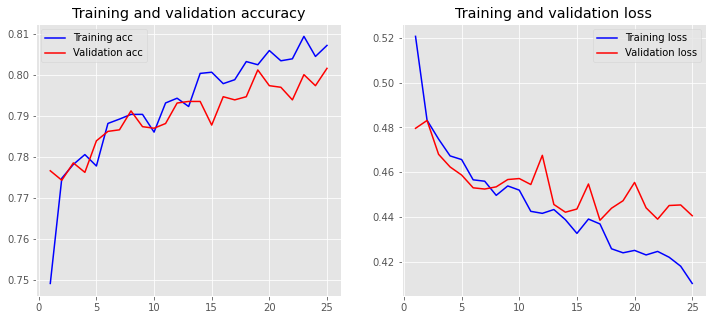

In [68]:
plot_history(mlp_model_history)

In [30]:
def toCategory(arr):  # Para pasar del vector de probabilidades al de predicciones del target
    return [1 if arr[i][0]>=0.5 else 0 for i in range(len(arr))]

In [80]:
# Predicciones
mlp_model_validation = toCategory(mlp_model.predict([X_val_text, X_val_nf]))

In [81]:
# Más evaluación: F1-Score

print('ERROR DE VALIDACION:\n')
print('El F1-Score es: {} \n'.format(f1_score(y_val, mlp_model_validation)))
print('La confusion matrix es: \n{} \n'.format(confusion_matrix(y_val, mlp_model_validation)))
print('El classification report es: \n{} \n'.format(classification_report(y_val, mlp_model_validation)))

ERROR DE VALIDACION:

El F1-Score es: 0.7924528301886793 

La confusion matrix es: 
[[1102  201]
 [ 316  987]] 

El classification report es: 
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1303
           1       0.83      0.76      0.79      1303

    accuracy                           0.80      2606
   macro avg       0.80      0.80      0.80      2606
weighted avg       0.80      0.80      0.80      2606
 



In [69]:
# Predicciones
mlp_model_prediction = toCategory(mlp_model.predict([X_test_text, X_test_nf]))

In [72]:
submission = pd.read_csv('./test.csv')

In [73]:
submission = submission.merge(pd.DataFrame(mlp_model_prediction), how = 'inner', on = submission.index)

In [75]:
submission = submission[['id', 0]]

In [76]:
submission.rename(columns = {0: 'target'}, inplace = True)

/home/martin/Datos/TP2/venvTP2/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [78]:
submission['target'].value_counts()

0    2016
1    1247
Name: target, dtype: int64

In [79]:
submission.to_csv('submission09082020.csv', index = False)

## MLP - HP Tuning

In [16]:
# Parámetros
no_trials = 25
batch_size = 32
no_epochs = 20

In [17]:
# Creación del modelo iterable para tuning

def get_tuning_model(hp):
    inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
    inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados

    x = layers.Concatenate(axis = 1)([inputs1, inputs2])  # Combinación de las salidas de ambas ramas
    
    for i in range(hp.Int('layers', 1, 3)):
        if i == 0:
            x = layers.Dropout(0.5)(x)
        x = layers.Dense(units=hp.Int('units_'+str(i), min_value=256, max_value=512, step=32), activation="relu")(x)
        x = layers.BatchNormalization(axis=-1, trainable=False)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate = 0.002)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [18]:
mlp_tuner = BayesianOptimization(get_tuning_model, objective = "val_loss", max_trials = no_trials, num_initial_points=2, 
                                 seed=666, directory='mlp_tuner', project_name='mlp_tuner')
mlp_tuner.search_space_summary()

In [19]:
mlp_tuning_history = mlp_tuner.search([X_train_text, X_train_nf], y_train, 
                                      validation_data = ([X_val_text, X_val_nf], y_val), 
                                      batch_size = batch_size, epochs = no_epochs, verbose = 2)

Epoch 1/20
326/326 - 1s - loss: 0.5103 - accuracy: 0.7603 - val_loss: 0.4514 - val_accuracy: 0.7966
Epoch 2/20
326/326 - 1s - loss: 0.4761 - accuracy: 0.7739 - val_loss: 0.4281 - val_accuracy: 0.8020
Epoch 3/20
326/326 - 1s - loss: 0.4668 - accuracy: 0.7828 - val_loss: 0.4281 - val_accuracy: 0.8047
Epoch 4/20
326/326 - 1s - loss: 0.4581 - accuracy: 0.7875 - val_loss: 0.4371 - val_accuracy: 0.8043
Epoch 5/20
326/326 - 1s - loss: 0.4591 - accuracy: 0.7881 - val_loss: 0.4347 - val_accuracy: 0.7951
Epoch 6/20
326/326 - 1s - loss: 0.4441 - accuracy: 0.7956 - val_loss: 0.4155 - val_accuracy: 0.8047
Epoch 7/20
326/326 - 1s - loss: 0.4449 - accuracy: 0.7914 - val_loss: 0.4155 - val_accuracy: 0.8127
Epoch 8/20
326/326 - 1s - loss: 0.4405 - accuracy: 0.7990 - val_loss: 0.4129 - val_accuracy: 0.8154
Epoch 9/20
326/326 - 1s - loss: 0.4370 - accuracy: 0.8003 - val_loss: 0.4093 - val_accuracy: 0.8120
Epoch 10/20
326/326 - 1s - loss: 0.4275 - accuracy: 0.7999 - val_loss: 0.4207 - val_accuracy: 0.8124

Epoch 1/20
326/326 - 1s - loss: 0.5100 - accuracy: 0.7547 - val_loss: 0.4436 - val_accuracy: 0.7966
Epoch 2/20
326/326 - 1s - loss: 0.4771 - accuracy: 0.7762 - val_loss: 0.4393 - val_accuracy: 0.7951
Epoch 3/20
326/326 - 1s - loss: 0.4670 - accuracy: 0.7797 - val_loss: 0.4416 - val_accuracy: 0.7997
Epoch 4/20
326/326 - 1s - loss: 0.4552 - accuracy: 0.7875 - val_loss: 0.4312 - val_accuracy: 0.8012
Epoch 5/20
326/326 - 1s - loss: 0.4559 - accuracy: 0.7895 - val_loss: 0.4652 - val_accuracy: 0.7870
Epoch 6/20
326/326 - 1s - loss: 0.4473 - accuracy: 0.7935 - val_loss: 0.4268 - val_accuracy: 0.8043
Epoch 7/20
326/326 - 1s - loss: 0.4472 - accuracy: 0.7890 - val_loss: 0.4260 - val_accuracy: 0.8101
Epoch 8/20
326/326 - 1s - loss: 0.4418 - accuracy: 0.7953 - val_loss: 0.4257 - val_accuracy: 0.8070
Epoch 9/20
326/326 - 1s - loss: 0.4375 - accuracy: 0.7953 - val_loss: 0.4184 - val_accuracy: 0.8120
Epoch 10/20
326/326 - 1s - loss: 0.4292 - accuracy: 0.7982 - val_loss: 0.4230 - val_accuracy: 0.8147

Epoch 1/20
326/326 - 1s - loss: 0.5070 - accuracy: 0.7597 - val_loss: 0.4366 - val_accuracy: 0.7982
Epoch 2/20
326/326 - 1s - loss: 0.4756 - accuracy: 0.7794 - val_loss: 0.4408 - val_accuracy: 0.8031
Epoch 3/20
326/326 - 2s - loss: 0.4713 - accuracy: 0.7807 - val_loss: 0.4295 - val_accuracy: 0.8024
Epoch 4/20
326/326 - 1s - loss: 0.4619 - accuracy: 0.7860 - val_loss: 0.4350 - val_accuracy: 0.8035
Epoch 5/20
326/326 - 1s - loss: 0.4523 - accuracy: 0.7858 - val_loss: 0.4222 - val_accuracy: 0.8078
Epoch 6/20
326/326 - 1s - loss: 0.4513 - accuracy: 0.7876 - val_loss: 0.4264 - val_accuracy: 0.8104
Epoch 7/20
326/326 - 1s - loss: 0.4490 - accuracy: 0.7950 - val_loss: 0.4219 - val_accuracy: 0.8154
Epoch 8/20
326/326 - 1s - loss: 0.4408 - accuracy: 0.7935 - val_loss: 0.4217 - val_accuracy: 0.8093
Epoch 9/20
326/326 - 1s - loss: 0.4442 - accuracy: 0.7935 - val_loss: 0.4136 - val_accuracy: 0.8147
Epoch 10/20
326/326 - 1s - loss: 0.4369 - accuracy: 0.7984 - val_loss: 0.4138 - val_accuracy: 0.8093

Epoch 1/20
326/326 - 1s - loss: 0.5104 - accuracy: 0.7583 - val_loss: 0.4405 - val_accuracy: 0.7905
Epoch 2/20
326/326 - 1s - loss: 0.4722 - accuracy: 0.7814 - val_loss: 0.4304 - val_accuracy: 0.7943
Epoch 3/20
326/326 - 1s - loss: 0.4656 - accuracy: 0.7842 - val_loss: 0.4288 - val_accuracy: 0.8001
Epoch 4/20
326/326 - 1s - loss: 0.4578 - accuracy: 0.7891 - val_loss: 0.4364 - val_accuracy: 0.8028
Epoch 5/20
326/326 - 1s - loss: 0.4465 - accuracy: 0.7913 - val_loss: 0.4270 - val_accuracy: 0.8097
Epoch 6/20
326/326 - 1s - loss: 0.4472 - accuracy: 0.7909 - val_loss: 0.4208 - val_accuracy: 0.8058
Epoch 7/20
326/326 - 1s - loss: 0.4436 - accuracy: 0.7923 - val_loss: 0.4471 - val_accuracy: 0.7974
Epoch 8/20
326/326 - 1s - loss: 0.4424 - accuracy: 0.7959 - val_loss: 0.4197 - val_accuracy: 0.8120
Epoch 9/20
326/326 - 1s - loss: 0.4366 - accuracy: 0.7974 - val_loss: 0.4156 - val_accuracy: 0.8158
Epoch 10/20
326/326 - 1s - loss: 0.4367 - accuracy: 0.8023 - val_loss: 0.4096 - val_accuracy: 0.8108

Epoch 1/20
326/326 - 1s - loss: 0.5195 - accuracy: 0.7471 - val_loss: 0.4421 - val_accuracy: 0.7874
Epoch 2/20
326/326 - 1s - loss: 0.4828 - accuracy: 0.7681 - val_loss: 0.4310 - val_accuracy: 0.7989
Epoch 3/20
326/326 - 1s - loss: 0.4689 - accuracy: 0.7787 - val_loss: 0.4321 - val_accuracy: 0.7966
Epoch 4/20
326/326 - 1s - loss: 0.4633 - accuracy: 0.7829 - val_loss: 0.4226 - val_accuracy: 0.8035
Epoch 5/20
326/326 - 1s - loss: 0.4572 - accuracy: 0.7880 - val_loss: 0.4350 - val_accuracy: 0.8035
Epoch 6/20
326/326 - 1s - loss: 0.4586 - accuracy: 0.7830 - val_loss: 0.4239 - val_accuracy: 0.8097
Epoch 7/20
326/326 - 1s - loss: 0.4497 - accuracy: 0.7950 - val_loss: 0.4201 - val_accuracy: 0.8028
Epoch 8/20
326/326 - 1s - loss: 0.4526 - accuracy: 0.7940 - val_loss: 0.4223 - val_accuracy: 0.8089
Epoch 9/20
326/326 - 1s - loss: 0.4515 - accuracy: 0.7952 - val_loss: 0.4260 - val_accuracy: 0.8112
Epoch 10/20
326/326 - 1s - loss: 0.4502 - accuracy: 0.7896 - val_loss: 0.4248 - val_accuracy: 0.8089

Epoch 1/20
326/326 - 1s - loss: 0.5095 - accuracy: 0.7531 - val_loss: 0.4435 - val_accuracy: 0.7939
Epoch 2/20
326/326 - 1s - loss: 0.4753 - accuracy: 0.7769 - val_loss: 0.4437 - val_accuracy: 0.8001
Epoch 3/20
326/326 - 1s - loss: 0.4686 - accuracy: 0.7794 - val_loss: 0.4354 - val_accuracy: 0.8047
Epoch 4/20
326/326 - 1s - loss: 0.4577 - accuracy: 0.7839 - val_loss: 0.4230 - val_accuracy: 0.8024
Epoch 5/20
326/326 - 1s - loss: 0.4516 - accuracy: 0.7894 - val_loss: 0.4253 - val_accuracy: 0.8043
Epoch 6/20
326/326 - 1s - loss: 0.4443 - accuracy: 0.7921 - val_loss: 0.4221 - val_accuracy: 0.8116
Epoch 7/20
326/326 - 1s - loss: 0.4377 - accuracy: 0.7986 - val_loss: 0.4227 - val_accuracy: 0.8089
Epoch 8/20
326/326 - 1s - loss: 0.4374 - accuracy: 0.7963 - val_loss: 0.4186 - val_accuracy: 0.8108
Epoch 9/20
326/326 - 1s - loss: 0.4362 - accuracy: 0.8007 - val_loss: 0.4114 - val_accuracy: 0.8124
Epoch 10/20
326/326 - 1s - loss: 0.4334 - accuracy: 0.8035 - val_loss: 0.4089 - val_accuracy: 0.8181

Epoch 1/20
326/326 - 2s - loss: 0.5065 - accuracy: 0.7599 - val_loss: 0.4493 - val_accuracy: 0.7985
Epoch 2/20
326/326 - 1s - loss: 0.4767 - accuracy: 0.7792 - val_loss: 0.4380 - val_accuracy: 0.8012
Epoch 3/20
326/326 - 1s - loss: 0.4691 - accuracy: 0.7825 - val_loss: 0.4266 - val_accuracy: 0.8054
Epoch 4/20
326/326 - 1s - loss: 0.4672 - accuracy: 0.7825 - val_loss: 0.4295 - val_accuracy: 0.8024
Epoch 5/20
326/326 - 1s - loss: 0.4545 - accuracy: 0.7878 - val_loss: 0.4262 - val_accuracy: 0.8051
Epoch 6/20
326/326 - 1s - loss: 0.4465 - accuracy: 0.7912 - val_loss: 0.4290 - val_accuracy: 0.8051
Epoch 7/20
326/326 - 1s - loss: 0.4428 - accuracy: 0.7981 - val_loss: 0.4139 - val_accuracy: 0.8085
Epoch 8/20
326/326 - 1s - loss: 0.4434 - accuracy: 0.7918 - val_loss: 0.4230 - val_accuracy: 0.8089
Epoch 9/20
326/326 - 1s - loss: 0.4380 - accuracy: 0.7973 - val_loss: 0.4200 - val_accuracy: 0.8089
Epoch 10/20
326/326 - 1s - loss: 0.4297 - accuracy: 0.8038 - val_loss: 0.4178 - val_accuracy: 0.8150

Epoch 1/20
326/326 - 1s - loss: 0.5123 - accuracy: 0.7572 - val_loss: 0.4607 - val_accuracy: 0.7909
Epoch 2/20
326/326 - 1s - loss: 0.4767 - accuracy: 0.7771 - val_loss: 0.4376 - val_accuracy: 0.7932
Epoch 3/20
326/326 - 1s - loss: 0.4758 - accuracy: 0.7800 - val_loss: 0.4344 - val_accuracy: 0.8047
Epoch 4/20
326/326 - 1s - loss: 0.4591 - accuracy: 0.7853 - val_loss: 0.4213 - val_accuracy: 0.8062
Epoch 5/20
326/326 - 1s - loss: 0.4528 - accuracy: 0.7913 - val_loss: 0.4266 - val_accuracy: 0.8104
Epoch 6/20
326/326 - 1s - loss: 0.4539 - accuracy: 0.7899 - val_loss: 0.4213 - val_accuracy: 0.8085
Epoch 7/20
326/326 - 1s - loss: 0.4447 - accuracy: 0.7925 - val_loss: 0.4171 - val_accuracy: 0.8108
Epoch 8/20
326/326 - 1s - loss: 0.4375 - accuracy: 0.7944 - val_loss: 0.4131 - val_accuracy: 0.8127
Epoch 9/20
326/326 - 1s - loss: 0.4370 - accuracy: 0.7994 - val_loss: 0.4129 - val_accuracy: 0.8101
Epoch 10/20
326/326 - 1s - loss: 0.4358 - accuracy: 0.7994 - val_loss: 0.4186 - val_accuracy: 0.8127

Epoch 1/20
326/326 - 2s - loss: 0.5184 - accuracy: 0.7552 - val_loss: 0.4519 - val_accuracy: 0.7966
Epoch 2/20
326/326 - 2s - loss: 0.4831 - accuracy: 0.7741 - val_loss: 0.4289 - val_accuracy: 0.8005
Epoch 3/20
326/326 - 2s - loss: 0.4719 - accuracy: 0.7792 - val_loss: 0.4376 - val_accuracy: 0.8051
Epoch 4/20
326/326 - 2s - loss: 0.4591 - accuracy: 0.7852 - val_loss: 0.4393 - val_accuracy: 0.8012
Epoch 5/20
326/326 - 2s - loss: 0.4574 - accuracy: 0.7851 - val_loss: 0.4295 - val_accuracy: 0.8066
Epoch 6/20
326/326 - 2s - loss: 0.4545 - accuracy: 0.7873 - val_loss: 0.4242 - val_accuracy: 0.8039
Epoch 7/20
326/326 - 2s - loss: 0.4428 - accuracy: 0.7938 - val_loss: 0.4153 - val_accuracy: 0.8051
Epoch 8/20
326/326 - 2s - loss: 0.4378 - accuracy: 0.7950 - val_loss: 0.4186 - val_accuracy: 0.8120
Epoch 9/20
326/326 - 2s - loss: 0.4393 - accuracy: 0.7979 - val_loss: 0.4214 - val_accuracy: 0.8116
Epoch 10/20
326/326 - 2s - loss: 0.4382 - accuracy: 0.7972 - val_loss: 0.4171 - val_accuracy: 0.8131

Epoch 1/20
326/326 - 1s - loss: 0.5177 - accuracy: 0.7523 - val_loss: 0.4470 - val_accuracy: 0.8016
Epoch 2/20
326/326 - 1s - loss: 0.4761 - accuracy: 0.7788 - val_loss: 0.4279 - val_accuracy: 0.7970
Epoch 3/20
326/326 - 1s - loss: 0.4649 - accuracy: 0.7840 - val_loss: 0.4250 - val_accuracy: 0.8024
Epoch 4/20
326/326 - 1s - loss: 0.4608 - accuracy: 0.7865 - val_loss: 0.4215 - val_accuracy: 0.8039
Epoch 5/20
326/326 - 1s - loss: 0.4488 - accuracy: 0.7891 - val_loss: 0.4210 - val_accuracy: 0.8081
Epoch 6/20
326/326 - 1s - loss: 0.4479 - accuracy: 0.7908 - val_loss: 0.4182 - val_accuracy: 0.8062
Epoch 7/20
326/326 - 1s - loss: 0.4450 - accuracy: 0.7911 - val_loss: 0.4227 - val_accuracy: 0.8108
Epoch 8/20
326/326 - 1s - loss: 0.4461 - accuracy: 0.7915 - val_loss: 0.4351 - val_accuracy: 0.8008
Epoch 9/20
326/326 - 1s - loss: 0.4348 - accuracy: 0.7976 - val_loss: 0.4268 - val_accuracy: 0.8051
Epoch 10/20
326/326 - 1s - loss: 0.4307 - accuracy: 0.8006 - val_loss: 0.4235 - val_accuracy: 0.8054

Epoch 1/20
326/326 - 2s - loss: 0.5091 - accuracy: 0.7552 - val_loss: 0.4519 - val_accuracy: 0.7959
Epoch 2/20
326/326 - 2s - loss: 0.4808 - accuracy: 0.7747 - val_loss: 0.4404 - val_accuracy: 0.7947
Epoch 3/20
326/326 - 2s - loss: 0.4699 - accuracy: 0.7776 - val_loss: 0.4360 - val_accuracy: 0.8028
Epoch 4/20
326/326 - 2s - loss: 0.4609 - accuracy: 0.7829 - val_loss: 0.4323 - val_accuracy: 0.8039
Epoch 5/20
326/326 - 2s - loss: 0.4631 - accuracy: 0.7838 - val_loss: 0.4243 - val_accuracy: 0.8097
Epoch 6/20
326/326 - 2s - loss: 0.4581 - accuracy: 0.7811 - val_loss: 0.4212 - val_accuracy: 0.8097
Epoch 7/20
326/326 - 2s - loss: 0.4459 - accuracy: 0.7970 - val_loss: 0.4214 - val_accuracy: 0.8016
Epoch 8/20
326/326 - 2s - loss: 0.4389 - accuracy: 0.7964 - val_loss: 0.4242 - val_accuracy: 0.7978
Epoch 9/20
326/326 - 2s - loss: 0.4391 - accuracy: 0.7972 - val_loss: 0.4199 - val_accuracy: 0.8031
Epoch 10/20
326/326 - 2s - loss: 0.4317 - accuracy: 0.8052 - val_loss: 0.4142 - val_accuracy: 0.8139

Epoch 1/20
326/326 - 1s - loss: 0.5250 - accuracy: 0.7538 - val_loss: 0.4435 - val_accuracy: 0.7982
Epoch 2/20
326/326 - 1s - loss: 0.4793 - accuracy: 0.7745 - val_loss: 0.4323 - val_accuracy: 0.7974
Epoch 3/20
326/326 - 1s - loss: 0.4737 - accuracy: 0.7811 - val_loss: 0.4320 - val_accuracy: 0.7936
Epoch 4/20
326/326 - 1s - loss: 0.4685 - accuracy: 0.7819 - val_loss: 0.4269 - val_accuracy: 0.8062
Epoch 5/20
326/326 - 1s - loss: 0.4620 - accuracy: 0.7845 - val_loss: 0.4263 - val_accuracy: 0.8104
Epoch 6/20
326/326 - 1s - loss: 0.4573 - accuracy: 0.7907 - val_loss: 0.4239 - val_accuracy: 0.8089
Epoch 7/20
326/326 - 1s - loss: 0.4527 - accuracy: 0.7873 - val_loss: 0.4244 - val_accuracy: 0.8058
Epoch 8/20
326/326 - 1s - loss: 0.4504 - accuracy: 0.7892 - val_loss: 0.4199 - val_accuracy: 0.8005
Epoch 9/20
326/326 - 1s - loss: 0.4559 - accuracy: 0.7897 - val_loss: 0.4216 - val_accuracy: 0.8104
Epoch 10/20
326/326 - 1s - loss: 0.4484 - accuracy: 0.7943 - val_loss: 0.4185 - val_accuracy: 0.8131

Epoch 1/20
326/326 - 1s - loss: 0.5082 - accuracy: 0.7602 - val_loss: 0.4443 - val_accuracy: 0.7889
Epoch 2/20
326/326 - 1s - loss: 0.4785 - accuracy: 0.7759 - val_loss: 0.4382 - val_accuracy: 0.8039
Epoch 3/20
326/326 - 1s - loss: 0.4690 - accuracy: 0.7825 - val_loss: 0.4252 - val_accuracy: 0.7997
Epoch 4/20
326/326 - 1s - loss: 0.4594 - accuracy: 0.7857 - val_loss: 0.4244 - val_accuracy: 0.8081
Epoch 5/20
326/326 - 1s - loss: 0.4519 - accuracy: 0.7887 - val_loss: 0.4220 - val_accuracy: 0.8124
Epoch 6/20
326/326 - 1s - loss: 0.4450 - accuracy: 0.7875 - val_loss: 0.4164 - val_accuracy: 0.8104
Epoch 7/20
326/326 - 1s - loss: 0.4403 - accuracy: 0.7996 - val_loss: 0.4138 - val_accuracy: 0.8093
Epoch 8/20
326/326 - 1s - loss: 0.4398 - accuracy: 0.8007 - val_loss: 0.4190 - val_accuracy: 0.8085
Epoch 9/20
326/326 - 1s - loss: 0.4343 - accuracy: 0.7955 - val_loss: 0.4137 - val_accuracy: 0.8089
Epoch 10/20
326/326 - 1s - loss: 0.4309 - accuracy: 0.8017 - val_loss: 0.4117 - val_accuracy: 0.8112

Epoch 1/20
326/326 - 1s - loss: 0.5138 - accuracy: 0.7540 - val_loss: 0.4344 - val_accuracy: 0.7924
Epoch 2/20
326/326 - 1s - loss: 0.4770 - accuracy: 0.7769 - val_loss: 0.4364 - val_accuracy: 0.8089
Epoch 3/20
326/326 - 2s - loss: 0.4649 - accuracy: 0.7852 - val_loss: 0.4312 - val_accuracy: 0.8016
Epoch 4/20
326/326 - 1s - loss: 0.4573 - accuracy: 0.7879 - val_loss: 0.4212 - val_accuracy: 0.8058
Epoch 5/20
326/326 - 1s - loss: 0.4553 - accuracy: 0.7861 - val_loss: 0.4201 - val_accuracy: 0.8081
Epoch 6/20
326/326 - 1s - loss: 0.4480 - accuracy: 0.7956 - val_loss: 0.4292 - val_accuracy: 0.8054
Epoch 7/20
326/326 - 1s - loss: 0.4458 - accuracy: 0.7925 - val_loss: 0.4163 - val_accuracy: 0.8085
Epoch 8/20
326/326 - 1s - loss: 0.4379 - accuracy: 0.7965 - val_loss: 0.4192 - val_accuracy: 0.8097
Epoch 9/20
326/326 - 1s - loss: 0.4359 - accuracy: 0.8005 - val_loss: 0.4154 - val_accuracy: 0.8104
Epoch 10/20
326/326 - 1s - loss: 0.4391 - accuracy: 0.7946 - val_loss: 0.4124 - val_accuracy: 0.8085

Epoch 1/20
326/326 - 1s - loss: 0.5208 - accuracy: 0.7521 - val_loss: 0.4428 - val_accuracy: 0.7962
Epoch 2/20
326/326 - 1s - loss: 0.4803 - accuracy: 0.7761 - val_loss: 0.4340 - val_accuracy: 0.8031
Epoch 3/20
326/326 - 1s - loss: 0.4690 - accuracy: 0.7787 - val_loss: 0.4242 - val_accuracy: 0.8031
Epoch 4/20
326/326 - 1s - loss: 0.4664 - accuracy: 0.7839 - val_loss: 0.4302 - val_accuracy: 0.7947
Epoch 5/20
326/326 - 1s - loss: 0.4642 - accuracy: 0.7812 - val_loss: 0.4217 - val_accuracy: 0.8047
Epoch 6/20
326/326 - 1s - loss: 0.4549 - accuracy: 0.7897 - val_loss: 0.4252 - val_accuracy: 0.8054
Epoch 7/20
326/326 - 1s - loss: 0.4543 - accuracy: 0.7907 - val_loss: 0.4130 - val_accuracy: 0.8127
Epoch 8/20
326/326 - 1s - loss: 0.4492 - accuracy: 0.7956 - val_loss: 0.4157 - val_accuracy: 0.8062
Epoch 9/20
326/326 - 1s - loss: 0.4508 - accuracy: 0.7915 - val_loss: 0.4220 - val_accuracy: 0.8051
Epoch 10/20
326/326 - 1s - loss: 0.4471 - accuracy: 0.7944 - val_loss: 0.4268 - val_accuracy: 0.8005

Epoch 1/20
326/326 - 1s - loss: 0.5253 - accuracy: 0.7485 - val_loss: 0.4421 - val_accuracy: 0.8012
Epoch 2/20
326/326 - 1s - loss: 0.4818 - accuracy: 0.7701 - val_loss: 0.4325 - val_accuracy: 0.7974
Epoch 3/20
326/326 - 1s - loss: 0.4762 - accuracy: 0.7791 - val_loss: 0.4291 - val_accuracy: 0.8051
Epoch 4/20
326/326 - 1s - loss: 0.4627 - accuracy: 0.7838 - val_loss: 0.4253 - val_accuracy: 0.8051
Epoch 5/20
326/326 - 1s - loss: 0.4651 - accuracy: 0.7846 - val_loss: 0.4236 - val_accuracy: 0.8051
Epoch 6/20
326/326 - 1s - loss: 0.4628 - accuracy: 0.7869 - val_loss: 0.4151 - val_accuracy: 0.8108
Epoch 7/20
326/326 - 1s - loss: 0.4528 - accuracy: 0.7955 - val_loss: 0.4209 - val_accuracy: 0.8078
Epoch 8/20
326/326 - 1s - loss: 0.4572 - accuracy: 0.7881 - val_loss: 0.4177 - val_accuracy: 0.8135
Epoch 9/20
326/326 - 1s - loss: 0.4512 - accuracy: 0.7902 - val_loss: 0.4194 - val_accuracy: 0.8062
Epoch 10/20
326/326 - 1s - loss: 0.4505 - accuracy: 0.7896 - val_loss: 0.4187 - val_accuracy: 0.8166

Epoch 1/20
326/326 - 1s - loss: 0.5212 - accuracy: 0.7555 - val_loss: 0.4451 - val_accuracy: 0.7916
Epoch 2/20
326/326 - 1s - loss: 0.4763 - accuracy: 0.7736 - val_loss: 0.4305 - val_accuracy: 0.8047
Epoch 3/20
326/326 - 1s - loss: 0.4723 - accuracy: 0.7792 - val_loss: 0.4314 - val_accuracy: 0.7993
Epoch 4/20
326/326 - 1s - loss: 0.4670 - accuracy: 0.7831 - val_loss: 0.4270 - val_accuracy: 0.7966
Epoch 5/20
326/326 - 1s - loss: 0.4632 - accuracy: 0.7823 - val_loss: 0.4220 - val_accuracy: 0.8028
Epoch 6/20
326/326 - 1s - loss: 0.4583 - accuracy: 0.7889 - val_loss: 0.4224 - val_accuracy: 0.8054
Epoch 7/20
326/326 - 1s - loss: 0.4597 - accuracy: 0.7922 - val_loss: 0.4191 - val_accuracy: 0.8143
Epoch 8/20
326/326 - 1s - loss: 0.4581 - accuracy: 0.7872 - val_loss: 0.4435 - val_accuracy: 0.7924
Epoch 9/20
326/326 - 1s - loss: 0.4499 - accuracy: 0.7902 - val_loss: 0.4269 - val_accuracy: 0.8058
Epoch 10/20
326/326 - 1s - loss: 0.4575 - accuracy: 0.7895 - val_loss: 0.4181 - val_accuracy: 0.8108

Epoch 1/20
326/326 - 1s - loss: 0.5186 - accuracy: 0.7542 - val_loss: 0.4423 - val_accuracy: 0.7939
Epoch 2/20
326/326 - 1s - loss: 0.4837 - accuracy: 0.7729 - val_loss: 0.4350 - val_accuracy: 0.7989
Epoch 3/20
326/326 - 1s - loss: 0.4671 - accuracy: 0.7845 - val_loss: 0.4279 - val_accuracy: 0.8070
Epoch 4/20
326/326 - 1s - loss: 0.4684 - accuracy: 0.7825 - val_loss: 0.4218 - val_accuracy: 0.8051
Epoch 5/20
326/326 - 1s - loss: 0.4643 - accuracy: 0.7848 - val_loss: 0.4234 - val_accuracy: 0.8101
Epoch 6/20
326/326 - 1s - loss: 0.4617 - accuracy: 0.7872 - val_loss: 0.4219 - val_accuracy: 0.7993
Epoch 7/20
326/326 - 1s - loss: 0.4523 - accuracy: 0.7901 - val_loss: 0.4206 - val_accuracy: 0.8093
Epoch 8/20
326/326 - 1s - loss: 0.4543 - accuracy: 0.7937 - val_loss: 0.4197 - val_accuracy: 0.8078
Epoch 9/20
326/326 - 1s - loss: 0.4470 - accuracy: 0.7902 - val_loss: 0.4142 - val_accuracy: 0.8139
Epoch 10/20
326/326 - 1s - loss: 0.4432 - accuracy: 0.7969 - val_loss: 0.4199 - val_accuracy: 0.8104

Epoch 1/20
326/326 - 1s - loss: 0.5245 - accuracy: 0.7491 - val_loss: 0.4474 - val_accuracy: 0.7936
Epoch 2/20
326/326 - 1s - loss: 0.4861 - accuracy: 0.7702 - val_loss: 0.4340 - val_accuracy: 0.8005
Epoch 3/20
326/326 - 1s - loss: 0.4706 - accuracy: 0.7765 - val_loss: 0.4261 - val_accuracy: 0.8020
Epoch 4/20
326/326 - 1s - loss: 0.4690 - accuracy: 0.7798 - val_loss: 0.4362 - val_accuracy: 0.7997
Epoch 5/20
326/326 - 1s - loss: 0.4613 - accuracy: 0.7856 - val_loss: 0.4204 - val_accuracy: 0.8070
Epoch 6/20
326/326 - 1s - loss: 0.4597 - accuracy: 0.7894 - val_loss: 0.4264 - val_accuracy: 0.8047
Epoch 7/20
326/326 - 1s - loss: 0.4629 - accuracy: 0.7824 - val_loss: 0.4262 - val_accuracy: 0.8035
Epoch 8/20
326/326 - 1s - loss: 0.4572 - accuracy: 0.7880 - val_loss: 0.4248 - val_accuracy: 0.8093
Epoch 9/20
326/326 - 1s - loss: 0.4550 - accuracy: 0.7863 - val_loss: 0.4208 - val_accuracy: 0.8066
Epoch 10/20
326/326 - 1s - loss: 0.4604 - accuracy: 0.7899 - val_loss: 0.4358 - val_accuracy: 0.7974

Epoch 1/20
326/326 - 2s - loss: 0.5069 - accuracy: 0.7590 - val_loss: 0.4487 - val_accuracy: 0.7920
Epoch 2/20
326/326 - 2s - loss: 0.4823 - accuracy: 0.7770 - val_loss: 0.4440 - val_accuracy: 0.8035
Epoch 3/20
326/326 - 2s - loss: 0.4677 - accuracy: 0.7783 - val_loss: 0.4241 - val_accuracy: 0.8035
Epoch 4/20
326/326 - 2s - loss: 0.4630 - accuracy: 0.7808 - val_loss: 0.4272 - val_accuracy: 0.8066
Epoch 5/20
326/326 - 2s - loss: 0.4578 - accuracy: 0.7906 - val_loss: 0.4233 - val_accuracy: 0.8093
Epoch 6/20
326/326 - 2s - loss: 0.4540 - accuracy: 0.7909 - val_loss: 0.4243 - val_accuracy: 0.8039
Epoch 7/20
326/326 - 2s - loss: 0.4481 - accuracy: 0.7913 - val_loss: 0.4214 - val_accuracy: 0.8108
Epoch 8/20
326/326 - 2s - loss: 0.4398 - accuracy: 0.7957 - val_loss: 0.4201 - val_accuracy: 0.8170
Epoch 9/20
326/326 - 2s - loss: 0.4385 - accuracy: 0.7981 - val_loss: 0.4162 - val_accuracy: 0.8139
Epoch 10/20
326/326 - 2s - loss: 0.4332 - accuracy: 0.7970 - val_loss: 0.4115 - val_accuracy: 0.8170

Epoch 1/20
326/326 - 1s - loss: 0.5100 - accuracy: 0.7512 - val_loss: 0.4381 - val_accuracy: 0.7928
Epoch 2/20
326/326 - 1s - loss: 0.4797 - accuracy: 0.7766 - val_loss: 0.4457 - val_accuracy: 0.7989
Epoch 3/20
326/326 - 1s - loss: 0.4675 - accuracy: 0.7799 - val_loss: 0.4280 - val_accuracy: 0.8043
Epoch 4/20
326/326 - 1s - loss: 0.4577 - accuracy: 0.7861 - val_loss: 0.4314 - val_accuracy: 0.8039
Epoch 5/20
326/326 - 1s - loss: 0.4532 - accuracy: 0.7918 - val_loss: 0.4277 - val_accuracy: 0.8035
Epoch 6/20
326/326 - 1s - loss: 0.4522 - accuracy: 0.7908 - val_loss: 0.4250 - val_accuracy: 0.8054
Epoch 7/20
326/326 - 1s - loss: 0.4473 - accuracy: 0.7909 - val_loss: 0.4205 - val_accuracy: 0.8058
Epoch 8/20
326/326 - 1s - loss: 0.4382 - accuracy: 0.7964 - val_loss: 0.4148 - val_accuracy: 0.8112
Epoch 9/20
326/326 - 1s - loss: 0.4385 - accuracy: 0.7971 - val_loss: 0.4250 - val_accuracy: 0.8058
Epoch 10/20
326/326 - 1s - loss: 0.4341 - accuracy: 0.8001 - val_loss: 0.4123 - val_accuracy: 0.8108

Epoch 1/20
326/326 - 1s - loss: 0.5047 - accuracy: 0.7619 - val_loss: 0.4391 - val_accuracy: 0.8016
Epoch 2/20
326/326 - 1s - loss: 0.4791 - accuracy: 0.7751 - val_loss: 0.4276 - val_accuracy: 0.8035
Epoch 3/20
326/326 - 1s - loss: 0.4636 - accuracy: 0.7835 - val_loss: 0.4309 - val_accuracy: 0.7959
Epoch 4/20
326/326 - 1s - loss: 0.4584 - accuracy: 0.7842 - val_loss: 0.4258 - val_accuracy: 0.8035
Epoch 5/20
326/326 - 1s - loss: 0.4525 - accuracy: 0.7881 - val_loss: 0.4290 - val_accuracy: 0.8001
Epoch 6/20
326/326 - 1s - loss: 0.4520 - accuracy: 0.7931 - val_loss: 0.4307 - val_accuracy: 0.8051
Epoch 7/20
326/326 - 1s - loss: 0.4453 - accuracy: 0.7931 - val_loss: 0.4173 - val_accuracy: 0.8074
Epoch 8/20
326/326 - 1s - loss: 0.4382 - accuracy: 0.7978 - val_loss: 0.4185 - val_accuracy: 0.8085
Epoch 9/20
326/326 - 1s - loss: 0.4342 - accuracy: 0.8023 - val_loss: 0.4083 - val_accuracy: 0.8185
Epoch 10/20
326/326 - 1s - loss: 0.4351 - accuracy: 0.7963 - val_loss: 0.4115 - val_accuracy: 0.8120

Epoch 1/20
326/326 - 2s - loss: 0.5114 - accuracy: 0.7582 - val_loss: 0.4422 - val_accuracy: 0.7943
Epoch 2/20
326/326 - 2s - loss: 0.4805 - accuracy: 0.7759 - val_loss: 0.4332 - val_accuracy: 0.8028
Epoch 3/20
326/326 - 2s - loss: 0.4692 - accuracy: 0.7800 - val_loss: 0.4409 - val_accuracy: 0.7920
Epoch 4/20
326/326 - 2s - loss: 0.4616 - accuracy: 0.7832 - val_loss: 0.4265 - val_accuracy: 0.8097
Epoch 5/20
326/326 - 2s - loss: 0.4603 - accuracy: 0.7864 - val_loss: 0.4192 - val_accuracy: 0.8078
Epoch 6/20
326/326 - 2s - loss: 0.4550 - accuracy: 0.7864 - val_loss: 0.4221 - val_accuracy: 0.8047
Epoch 7/20
326/326 - 2s - loss: 0.4462 - accuracy: 0.7920 - val_loss: 0.4236 - val_accuracy: 0.8085
Epoch 8/20
326/326 - 2s - loss: 0.4394 - accuracy: 0.7988 - val_loss: 0.4190 - val_accuracy: 0.8078
Epoch 9/20
326/326 - 2s - loss: 0.4377 - accuracy: 0.8007 - val_loss: 0.4301 - val_accuracy: 0.8089
Epoch 10/20
326/326 - 2s - loss: 0.4350 - accuracy: 0.7952 - val_loss: 0.4248 - val_accuracy: 0.8108

Epoch 1/20
326/326 - 1s - loss: 0.5069 - accuracy: 0.7586 - val_loss: 0.4453 - val_accuracy: 0.7905
Epoch 2/20
326/326 - 1s - loss: 0.4790 - accuracy: 0.7783 - val_loss: 0.4384 - val_accuracy: 0.8031
Epoch 3/20
326/326 - 1s - loss: 0.4689 - accuracy: 0.7823 - val_loss: 0.4220 - val_accuracy: 0.8074
Epoch 4/20
326/326 - 1s - loss: 0.4622 - accuracy: 0.7860 - val_loss: 0.4203 - val_accuracy: 0.8081
Epoch 5/20
326/326 - 1s - loss: 0.4557 - accuracy: 0.7859 - val_loss: 0.4172 - val_accuracy: 0.8074
Epoch 6/20
326/326 - 1s - loss: 0.4453 - accuracy: 0.7931 - val_loss: 0.4143 - val_accuracy: 0.8124
Epoch 7/20
326/326 - 1s - loss: 0.4429 - accuracy: 0.7919 - val_loss: 0.4215 - val_accuracy: 0.8124
Epoch 8/20
326/326 - 1s - loss: 0.4411 - accuracy: 0.7953 - val_loss: 0.4097 - val_accuracy: 0.8116
Epoch 9/20
326/326 - 1s - loss: 0.4408 - accuracy: 0.7935 - val_loss: 0.4164 - val_accuracy: 0.8058
Epoch 10/20
326/326 - 1s - loss: 0.4369 - accuracy: 0.8008 - val_loss: 0.4142 - val_accuracy: 0.8173

Epoch 1/20
326/326 - 1s - loss: 0.5268 - accuracy: 0.7550 - val_loss: 0.4430 - val_accuracy: 0.7920
Epoch 2/20
326/326 - 1s - loss: 0.4848 - accuracy: 0.7750 - val_loss: 0.4330 - val_accuracy: 0.7978
Epoch 3/20
326/326 - 1s - loss: 0.4668 - accuracy: 0.7827 - val_loss: 0.4309 - val_accuracy: 0.8012
Epoch 4/20
326/326 - 1s - loss: 0.4649 - accuracy: 0.7813 - val_loss: 0.4364 - val_accuracy: 0.8043
Epoch 5/20
326/326 - 1s - loss: 0.4589 - accuracy: 0.7848 - val_loss: 0.4261 - val_accuracy: 0.8016
Epoch 6/20
326/326 - 1s - loss: 0.4578 - accuracy: 0.7847 - val_loss: 0.4234 - val_accuracy: 0.8058
Epoch 7/20
326/326 - 1s - loss: 0.4555 - accuracy: 0.7870 - val_loss: 0.4273 - val_accuracy: 0.8020
Epoch 8/20
326/326 - 1s - loss: 0.4565 - accuracy: 0.7901 - val_loss: 0.4237 - val_accuracy: 0.8066
Epoch 9/20
326/326 - 1s - loss: 0.4478 - accuracy: 0.7928 - val_loss: 0.4154 - val_accuracy: 0.8101
Epoch 10/20
326/326 - 1s - loss: 0.4470 - accuracy: 0.7887 - val_loss: 0.4107 - val_accuracy: 0.8127

INFO:tensorflow:Oracle triggered exit


## MLP - Cross Validation

In [20]:
# Parámetros
n_folds = 5
batch_size = 32
no_epochs = 25

In [21]:
def load_data_cv(TrainDF, TestDF, encode_keyword = False):
    # Numeric Features: Encoding de 'keyword' + Resultado de feature engineering
    print('Preparando las Numeric Features...')
    TrainDF_subset = TrainDF.drop(columns = ['id', 'keyword', 'location', 'text', 'target'])
    TestDF_subset = TestDF.drop(columns = ['id', 'keyword', 'location', 'text'])
    if encode_keyword == True:
        ohe = OneHotEncoder(handle_unknown = 'ignore')
        ohe.fit(np.array(TrainDF.loc[TrainDF['keyword'].isna() == False, 'keyword']).reshape((-1,1)))
        TrainDF['keyword'].fillna('NoKeyword', inplace = True)
        TrainDF_keyword_enc = ohe.transform(np.array(TrainDF['keyword']).reshape((-1,1)))
        TestDF['keyword'].fillna('NoKeyword', inplace = True)
        TestDF_keyword_enc = ohe.transform(np.array(TestDF['keyword']).reshape((-1,1)))
        print('El encoding genera {} nuevos features adicionales'.format(TrainDF_keyword_enc.shape[1]))
        X_train_nf = sparse.hstack((TrainDF_keyword_enc, sparse.csr_matrix(TrainDF_subset.values))).toarray()
        X_test_nf = sparse.hstack((TestDF_keyword_enc, sparse.csr_matrix(TestDF_subset.values))).toarray()
    else:
        X_train_nf = TrainDF_subset.to_numpy()
        X_test_nf = TestDF_subset.to_numpy()
    nf_norm_layer = layers.experimental.preprocessing.Normalization()
    nf_norm_layer.adapt(X_train_nf)
    X_train_nf = nf_norm_layer(X_train_nf)
    X_test_nf = nf_norm_layer(X_test_nf) 
    
    # Text: Formateo para embedding layer
    print('Preparando el texto... \n')
    X_train_text = np.stack(TrainDF['text'].map(lambda x: embed(x)))
    X_test_text = np.stack(TestDF['text'].map(lambda x: embed(x)))
    nf_norm_layer_text = layers.experimental.preprocessing.Normalization()
    nf_norm_layer_text.adapt(X_train_text)
    X_train_text = nf_norm_layer_text(X_train_text)
    X_test_text = nf_norm_layer_text(X_test_text)
    
    # Target
    y_train = np.array(TrainDF['target'])
    
    print('''Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: {}
        Set de entrenamiento, texto: {}
        Set de test, features numéricos: {}
        Set de test, texto: {}'''.format(X_train_nf.shape, X_train_text.shape, X_test_nf.shape, X_test_text.shape))
    
    return X_train_text, X_train_nf, X_test_text, X_test_nf, y_train

In [22]:
# Sets de datos
X_train_text, X_train_nf, X_test_text, X_test_nf, y_train = load_data_cv(tw_train_noisy_balanced, tw_test)

# Almacenamiento de la información de entrenamiento
acc_per_fold = []
loss_per_fold = []

# Índices para separación
skf = StratifiedKFold(n_splits=n_folds, random_state = 123, shuffle = True)

Preparando las Numeric Features...
Preparando el texto... 

Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: (13026, 24)
        Set de entrenamiento, texto: (13026, 100)
        Set de test, features numéricos: (3263, 24)
        Set de test, texto: (3263, 100)


In [23]:
# Creación del modelo iterable
def get_compiled_model():
    inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
    inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados

    x = layers.Concatenate(axis = 1)([inputs1, inputs2])  # Combinación de las salidas de ambas ramas
    
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(320, activation="relu")(x)
    x = layers.BatchNormalization(trainable = False)(x)
    x = layers.Dense(416, activation="relu")(x)
    x = layers.BatchNormalization(trainable = False)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.002), metrics=["accuracy"])
    return model

In [24]:
# K-fold Cross Validation
fold_no = 1
for train, validation in skf.split(X_train_text, y_train):
    fold_model = get_compiled_model()
    
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    
    # Fit data to model
    history = fold_model.fit([tf.gather(X_train_text, train), tf.gather(X_train_nf, train)], y_train[train], 
                             batch_size = batch_size, epochs = no_epochs, verbose = 2)

    # Generate generalization metrics
    scores = fold_model.evaluate([tf.gather(X_train_text, validation), tf.gather(X_train_nf, validation)], y_train[validation], verbose = 2)
    print(f'\nScore for fold {fold_no}: {fold_model.metrics_names[0]} of {scores[0]}; {fold_model.metrics_names[1]} of {scores[1]*100}% \n')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
    
# Average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
print('\nAverage scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/25
326/326 - 1s - loss: 0.5116 - accuracy: 0.7563
Epoch 2/25
326/326 - 1s - loss: 0.4811 - accuracy: 0.7739
Epoch 3/25
326/326 - 1s - loss: 0.4670 - accuracy: 0.7796
Epoch 4/25
326/326 - 1s - loss: 0.4585 - accuracy: 0.7839
Epoch 5/25
326/326 - 1s - loss: 0.4604 - accuracy: 0.7857
Epoch 6/25
326/326 - 1s - loss: 0.4496 - accuracy: 0.7907
Epoch 7/25
326/326 - 1s - loss: 0.4445 - accuracy: 0.7946
Epoch 8/25
326/326 - 1s - loss: 0.4421 - accuracy: 0.7959
Epoch 9/25
326/326 - 1s - loss: 0.4447 - accuracy: 0.7971
Epoch 10/25
326/326 - 1s - loss: 0.4353 - accuracy: 0.7976
Epoch 11/25
326/326 - 1s - loss: 0.4337 - accuracy: 0.8029
Epoch 12/25
326/326 - 1s - loss: 0.4268 - accuracy: 0.8060
Epoch 13/25
326/326 - 1s - loss: 0.4219 - accuracy: 0.8060
Epoch 14/25
326/326 - 1s - loss: 0.4172 - accuracy: 0.8062
Epoch 15/25
326/326 - 1s - loss: 0.4144 - accuracy: 0.8113
Epoch 16/25
326/326 - 1s - 

## MLP - Reentrenamiento con nuevos parámetros y set completo

In [25]:
# Sets de datos
X_train_text, X_train_nf, X_test_text, X_test_nf, y_train = load_data_cv(tw_train_noisy_balanced, tw_test)

Preparando las Numeric Features...
Preparando el texto... 

Las dimensiones de los sets de datos son:
        Set de entrenamiento, features numéricos: (13026, 24)
        Set de entrenamiento, texto: (13026, 100)
        Set de test, features numéricos: (3263, 24)
        Set de test, texto: (3263, 100)


In [35]:

inputs1 = keras.Input(batch_size = None, shape = (X_train_text.shape[1],))  # Entrada del texto vectorizado según myVocabulary
inputs2 = keras.Input(batch_size = None, shape = (X_train_nf.shape[1],))  # Entrada de los features numéricos completamente pre-procesados

x = layers.Concatenate(axis = 1)([inputs1, inputs2])  # Combinación de las salidas de ambas ramas

x = layers.Dropout(0.5)(x)
x = layers.Dense(288, activation="relu")(x)
x = layers.BatchNormalization(trainable = False)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization(trainable = False)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

mlp_model = keras.Model(inputs=[inputs1, inputs2], outputs=outputs)

In [36]:
mlp_model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.002), metrics=["accuracy"])

In [37]:
mlp_model_history = mlp_model.fit([X_train_text, X_train_nf], y_train, 
                    batch_size = 32, epochs = 25, verbose = 2)

Epoch 1/25
408/408 - 1s - loss: 0.5040 - accuracy: 0.7578
Epoch 2/25
408/408 - 1s - loss: 0.4694 - accuracy: 0.7797
Epoch 3/25
408/408 - 1s - loss: 0.4593 - accuracy: 0.7864
Epoch 4/25
408/408 - 1s - loss: 0.4580 - accuracy: 0.7853
Epoch 5/25
408/408 - 1s - loss: 0.4525 - accuracy: 0.7944
Epoch 6/25
408/408 - 1s - loss: 0.4415 - accuracy: 0.7928
Epoch 7/25
408/408 - 1s - loss: 0.4429 - accuracy: 0.7937
Epoch 8/25
408/408 - 1s - loss: 0.4408 - accuracy: 0.7966
Epoch 9/25
408/408 - 1s - loss: 0.4339 - accuracy: 0.7969
Epoch 10/25
408/408 - 1s - loss: 0.4345 - accuracy: 0.7994
Epoch 11/25
408/408 - 1s - loss: 0.4314 - accuracy: 0.7969
Epoch 12/25
408/408 - 1s - loss: 0.4222 - accuracy: 0.8048
Epoch 13/25
408/408 - 1s - loss: 0.4225 - accuracy: 0.8054
Epoch 14/25
408/408 - 1s - loss: 0.4227 - accuracy: 0.8049
Epoch 15/25
408/408 - 1s - loss: 0.4216 - accuracy: 0.8047
Epoch 16/25
408/408 - 1s - loss: 0.4129 - accuracy: 0.8129
Epoch 17/25
408/408 - 1s - loss: 0.4119 - accuracy: 0.8100
Epoch 

In [38]:
# Predicciones
mlp_model_prediction = toCategory(mlp_model.predict([X_test_text, X_test_nf]))

In [40]:
submission = pd.read_csv('./test.csv')

In [41]:
submission = submission.merge(pd.DataFrame(mlp_model_prediction), how = 'inner', on = submission.index)

In [42]:
submission = submission[['id', 0]]

In [43]:
submission.rename(columns = {0: 'target'}, inplace = True)

In [44]:
submission.to_csv('submission10082020.csv', index = False)